# Gold standard judge dataset
This is the equivalent of SME labelling

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from dspy_judge.llm_caller.utils import load_secrets
from dspy_judge.data_loader.dataset_loader import CustomerSupportDatasetLoader
from dspy_judge.processor.parallel_processor import ParallelProcessor
from dspy_judge.prompts.dspy_signatures import SupportTranscriptJudge
from dspy_judge.processor.utils import convert_dataset_to_dspy_examples, extract_llm_response_fields_dspy
from dspy_judge.processor.parallel_processor import ParallelProcessor
from dspy_judge.metrics import match_judge_metric
from dspy_judge.plotting import plot_judge_results
import numpy as np
from sklearn.metrics import cohen_kappa_score
import dspy

/Users/rmartinshort/Documents/DS_projects/dspy_judge/judgemodel/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
secrets = load_secrets()

## Load split dataset (final output of notebook 1)

In [7]:
data_loader = CustomerSupportDatasetLoader()
split_dataset = data_loader.load_local_dataset("datasets/preprocessed_dev_judge_dataset_split/")

Local dataset loaded from datasets/preprocessed_dev_judge_dataset_split/. Size: 2


In [8]:
dev_dataset = split_dataset["train"]
judge_dataset = split_dataset["test"]

## Set up gold standard judge

In [ ]:
gold_standard_judge_generator_module = dspy.ChainOfThought(SupportTranscriptJudge)

In [9]:
dspy_config = {
      "model_name": "anthropic/claude-opus-4-20250514",
      "api_key": secrets["ANTHROPIC_API_KEY"],
      "temperature": 0
}

gold_standard_judge_generator_module = dspy.ChainOfThought(SupportTranscriptJudge)

gold_standard_dspy_judge_processor = ParallelProcessor()

dspy_judge_results_optimized = gold_standard_dspy_judge_processor.process_dataset_with_dspy(
  judge_dataset.select_columns(
    ["conversation_id","output_transcript"]
  ),
  input_field="output_transcript",
  dspy_module=gold_standard_judge_generator_module,
  dspy_config=dspy_config
)

******************************
{'docstring': "You are a very experienced customer service agent who has worked in multiple industries and understands how to address\na very large range of issues. Your task is to help train more junior customer service agents by looking at how they responded \nto real queries and judging whether or not the interaction was successful. \nA successful interaction is somewhat subjective and you will lean on your expertise when making the judgment. In general, the\nresponses from the agent being judged should:\n1. Provide a solid answer to the question if one is asked. If the agent doesn't know the answer, or there is no clear answer, that's OK, \nbut the agent should clearly explain that they don't know and offer suggestions for where to find more information. \n2. The agent's response should always be polite and understanding, even if the customer is angry.\n3. Sometimes customers make comments that can't really be acted upon. In these situations, the agen

Processing with DSPy:   0%|                                                                                                | 0/160 [00:00<?, ?it/s]2025/08/16 13:35:16 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/16 13:35:16 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/16 13:35:16 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/16 13:35:16 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/16 13:35:19 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
Processing with DSPy:   1%|▌                                                                                       | 1/160 [00:05<15:47,  5.96s/it]2025/08/16 13:35:19 WARNING dspy.adapters.json_adapter: Failed to use structured output for

In [ ]:
dspy_judge_results_optimized.to_pandas().iloc[0]["dspy_response"]

In [10]:
gold_standard_dspy_judge_results = dspy_judge_results_optimized.map(
    extract_llm_response_fields_dspy
)

Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 11047.45 examples/s]


In [11]:
gold_standard_dspy_judge_results

Dataset({
    features: ['conversation_id', 'output_transcript', 'dspy_response', 'dspy_metadata', 'explanation', 'satisfied'],
    num_rows: 160
})

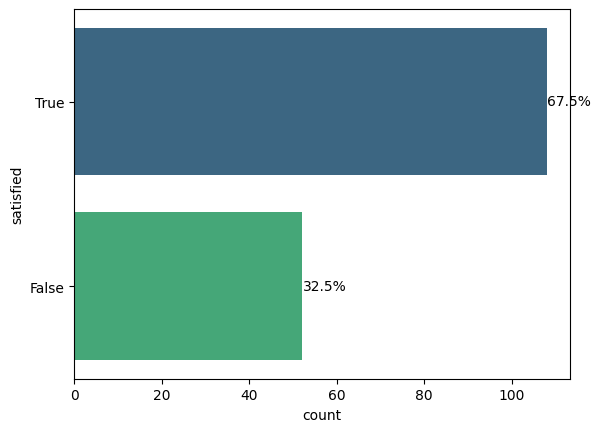

In [12]:
plot_judge_results(
    gold_standard_dspy_judge_results.to_pandas()
)

## Save gold standard result

In [ ]:
data_loader.save_dataset_locally(
    dspy_gold_standard_judge_results,"datasets/gold_standard_judge_result"
)